In [1]:
import pandas as pd
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader
from IPython.display import display
from clip_retrieval.clip_client import ClipClient, Modality
from IPython.display import Image, display
from base64 import b64decode
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from copy import deepcopy
import json
import open_clip
from PIL import Image as PILImage
import os
import itertools
import wandb

os.chdir('/workspace')
from rtpt.rtpt import setproctitle
setproctitle('@Clipping_Privacy_LAION400M_Notebook')

from utils import TQDMParallel

In [2]:
# if false, the results are loaded from the csv file
QUERY_BACKEND = False
CHECK_FACESCRUB_MEMBERSHIP = False
CHECK_GERMAN_MEMBERSHIP = False
NUM_IMAGES = 200
MIN_IMAGES_PER_ACTOR_TO_USE_FOR_MEMBERS_AND_NON_MEMBERS = 30
# to run this code you have to start multiple docker containers and run `clip_retrieval` for the LAION-400M dataset in each of the containers
# after starting the docker containers get the ip addresses using the followinig command:
# docker inspect -f '{{range.NetworkSettings.Networks}}{{.IPAddress}}{{end}}' <docker_container_name>"
CLIENT_URLS = [
    'http://172.17.0.22:1337/knn-service',
    'http://172.17.0.21:1337/knn-service',
    'http://172.17.0.20:1337/knn-service',
    'http://172.17.0.19:1337/knn-service',
    'http://172.17.0.18:1337/knn-service',
    'http://172.17.0.17:1337/knn-service',
    'http://172.17.0.16:1337/knn-service',
    'http://172.17.0.15:1337/knn-service',
    'http://172.17.0.14:1337/knn-service',
    'http://172.17.0.13:1337/knn-service',
    'http://172.17.0.12:1337/knn-service',
    'http://172.17.0.11:1337/knn-service',
    'http://172.17.0.10:1337/knn-service',
    'http://172.17.0.9:1337/knn-service',
    'http://172.17.0.8:1337/knn-service',
    'http://172.17.0.7:1337/knn-service',
    'http://172.17.0.6:1337/knn-service',
    'http://172.17.0.5:1337/knn-service',
    'http://172.17.0.4:1337/knn-service',
    'http://172.17.0.3:1337/knn-service'
]

In [3]:
clients = []
for url in CLIENT_URLS:
    clients.append(
        ClipClient(
            url=url,
            indice_name='LAION-400M',
            aesthetic_weight=0,
            modality=Modality.IMAGE,
            use_safety_model=False,
            use_violence_detector=False,
            deduplicate=False,
            num_images=NUM_IMAGES
        )
    )
len(clients)

def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))

# Test Clip Retrieval to make sure it works properly

In [4]:
if QUERY_BACKEND:
    for client in clients:
        res = client.query(text='an image of a cat')
        assert len(res) == NUM_IMAGES
    cat = clients[-1].query(text='an image of a cat')
    print(len(cat))
    log_result(cat[0])

# Load the FaceScrub Dataset

In [5]:
actors_dataset = ImageFolder(root='./data/facescrub/actors/images')
actresses_dataset = ImageFolder(root='./data/facescrub/actresses/images')

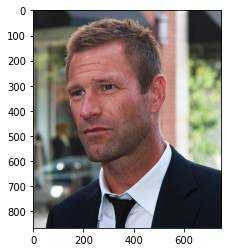

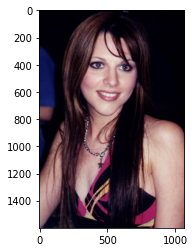

In [6]:
plt.imshow(actors_dataset[0][0])
plt.show()
plt.imshow(actresses_dataset[0][0])
plt.show()

# Get the NUM_IMAGES most similar images to each of the images in the FaceScrub dataset

In [7]:
def get_similar_images(img, clip_retrieval_client):
    res = []
    try:
        res = clip_retrieval_client.query(image=img)
    except Exception as e:
        print(f"Exception: {e}")
    
    # if there was an internal server error just ignore the result
    if len(res) == 1:
        res = []
    
    return res

In [8]:
if QUERY_BACKEND:
    # get the similar images as list
    sim_imgs_actors = TQDMParallel(n_jobs=len(clients), total=len(actors_dataset))(delayed(get_similar_images)(actors_dataset.imgs[i][0], clients[i%len(clients)]) for i in range(len(actors_dataset.imgs)))

    # convert the list to a dictionary
    actors_sim_imgs = {}
    for i, (img, cls)in enumerate(actors_dataset.imgs):
        actors_sim_imgs[img] = sim_imgs_actors[i]

    # save the dictionary as a json file
    with open(f'laion400m_experiments/face_scrub_top{NUM_IMAGES}_similar_laion400m_images_actors.json', 'w') as json_file:
        json_file.write(json.dumps(actors_sim_imgs))
elif CHECK_FACESCRUB_MEMBERSHIP:
    with open(f'laion400m_experiments/face_scrub_top{NUM_IMAGES}_similar_laion400m_images_actors.json', 'r') as json_file:
        actors_sim_imgs = json.load(json_file)

In [9]:
if QUERY_BACKEND:
    # do the same as above for the actresses
    # get the similar images as list
    sim_imgs_actresses = TQDMParallel(n_jobs=len(clients), total=len(actresses_dataset))(delayed(get_similar_images)(actresses_dataset.imgs[i][0], clients[i%len(clients)]) for i in range(len(actresses_dataset.imgs)))

    # convert the list to a dictionary
    actresses_sim_imgs = {}
    for i, (img, cls)in enumerate(actresses_dataset.imgs):
        actresses_sim_imgs[img] = sim_imgs_actresses[i]

    # save the dictionary as a json file
    with open(f'laion400m_experiments/face_scrub_top{NUM_IMAGES}_similar_laion400m_images_actresses.json', 'w') as json_file:
        json_file.write(json.dumps(actresses_sim_imgs))
elif CHECK_FACESCRUB_MEMBERSHIP:
    with open(f'laion400m_experiments/face_scrub_top{NUM_IMAGES}_similar_laion400m_images_actresses.json', 'r') as json_file:
        actresses_sim_imgs = json.load(json_file)

In [10]:
def create_df(sim_imgs):
    dataframes = []
    for key in sim_imgs.keys():
        df = pd.DataFrame(sim_imgs[key])
        df['image'] = key
        dataframes.append(df)
    
    df = pd.concat(dataframes, ignore_index=True)

    df = df[list(df.columns)[::-1]]
    df['class_name'] = df.image.str.split('/').str[-1].str.split('.').str[:-1].str.join('.').str.split('_').str[:-1].str.join('_')

    # fix the names of the actors and actresses
    df.loc[df['class_name'] == 'Freddy_Prinze_Jr.', 'class_name'] = 'Freddie_Prinze_Jr'
    df.loc[df['class_name'] == 'Leslie_Neilsen', 'class_name'] = 'Leslie_Nielsen'
    df.loc[df['class_name'] == 'Robert_Di_Niro', 'class_name'] = 'Robert_De_Niro'
    df.loc[df['class_name'] == 'Tatyana_M._Ali', 'class_name'] = 'Tatyana_Ali'
    

    df['name'] = df['class_name'].apply(lambda x: x.replace("_", " "))
    df['name_in_caption'] = df.apply(lambda x: x['name'] in x['caption'], axis='columns')

    return df

if CHECK_FACESCRUB_MEMBERSHIP:
    actresses_df = create_df(actresses_sim_imgs)
    actors_df = create_df(actors_sim_imgs)
    df = pd.concat([actors_df, actresses_df], ignore_index=True)
    display(df)

In [11]:
if CHECK_FACESCRUB_MEMBERSHIP:
    num_images_per_actor = (df.groupby(['class_name']).size() / NUM_IMAGES).sort_values()
    actors_with_num_images_above_threshold = num_images_per_actor[num_images_per_actor >= MIN_IMAGES_PER_ACTOR_TO_USE_FOR_MEMBERS_AND_NON_MEMBERS]
    
    grouped_caption_checks = df.groupby(['class_name', 'name_in_caption']).size().unstack(fill_value=0)

    fs_non_members = grouped_caption_checks[grouped_caption_checks[True] == 0].reset_index()
    fs_non_members = pd.merge(fs_non_members, actors_with_num_images_above_threshold.reset_index()['class_name'], on='class_name', how='inner').reset_index(drop=True)
    fs_non_members.to_csv('./laion400m_experiments/laion400m_fs_non_members.csv')

    fs_members = grouped_caption_checks[grouped_caption_checks[True] > 0].reset_index()
    fs_members = pd.merge(fs_members, actors_with_num_images_above_threshold.reset_index()['class_name'], on='class_name', how='inner').reset_index(drop=True)
    fs_members.to_csv('./laion400m_experiments/laion400m_fs_members.csv')
else:
    fs_non_members = pd.read_csv('./laion400m_experiments/laion400m_fs_non_members.csv', index_col=0)
    fs_members = pd.read_csv('./laion400m_experiments/laion400m_fs_members.csv', index_col=0)
print('Non-Members')
display(fs_non_members)
print('Members')
display(fs_members)

Non-Members


,class_name,False,True
0,Jenilee_Harrison,6200,0
1,Jessica_Leccia,7200,0
2,Mackenzie_Aladjem,9000,0


Members


,class_name,False,True
0,Aaron_Eckhart,11624,6576
1,Adam_Brody,16259,2741
2,Adam_Sandler,10215,4185
3,Adrien_Brody,11741,6859
4,Adrienne_Barbeau,7833,767
...,...,...,...
499,Victoria_Justice,13343,7657
500,Wendie_Malick,13000,1600
501,Woody_Allen,4764,6636
502,Yasmine_Bleeth,11669,731


# Check Membership of the German Actors and Actresses

In [12]:
actors_dataset = ImageFolder(root='./data/laion_german_non_members/actors/images')
actresses_dataset = ImageFolder(root='./data/laion_german_non_members/actresses/images')

In [13]:
if QUERY_BACKEND:
    # get the similar images as list
    sim_imgs_actors = TQDMParallel(n_jobs=len(clients), total=len(actors_dataset))(delayed(get_similar_images)(actors_dataset.imgs[i][0], clients[i%len(clients)]) for i in range(len(actors_dataset.imgs)))

    # convert the list to a dictionary
    actors_sim_imgs = {}
    for i, (img, cls)in enumerate(actors_dataset.imgs):
        actors_sim_imgs[img] = sim_imgs_actors[i]

    # save the dictionary as a json file
    with open(f'laion400m_experiments/german_top{NUM_IMAGES}_similar_laion400m_images_actors.json', 'w') as json_file:
        json_file.write(json.dumps(actors_sim_imgs))
elif CHECK_GERMAN_MEMBERSHIP:
    with open(f'laion400m_experiments/german_top{NUM_IMAGES}_similar_laion400m_images_actors.json', 'r') as json_file:
        actors_sim_imgs = json.load(json_file)

In [14]:
if QUERY_BACKEND:
    # do the same as above for the actresses
    # get the similar images as list
    sim_imgs_actresses = TQDMParallel(n_jobs=len(clients), total=len(actresses_dataset))(delayed(get_similar_images)(actresses_dataset.imgs[i][0], clients[i%len(clients)]) for i in range(len(actresses_dataset.imgs)))

    # convert the list to a dictionary
    actresses_sim_imgs = {}
    for i, (img, cls)in enumerate(actresses_dataset.imgs):
        actresses_sim_imgs[img] = sim_imgs_actresses[i]

    # save the dictionary as a json file
    with open(f'laion400m_experiments/german_top{NUM_IMAGES}_similar_laion400m_images_actresses.json', 'w') as json_file:
        json_file.write(json.dumps(actresses_sim_imgs))
elif CHECK_GERMAN_MEMBERSHIP:
    with open(f'laion400m_experiments/german_top{NUM_IMAGES}_similar_laion400m_images_actresses.json', 'r') as json_file:
        actresses_sim_imgs = json.load(json_file)

In [15]:
def create_df(sim_imgs):
    dataframes = []
    for key in sim_imgs.keys():
        df = pd.DataFrame(sim_imgs[key])
        df['image'] = key
        dataframes.append(df)
    
    df = pd.concat(dataframes, ignore_index=True)

    df = df[list(df.columns)[::-1]]
    df['class_name'] = df.image.str.split('/').str[-1].str.split('.').str[:-1].str.join('.').str.split('_').str[:-1].str.join('_')
    df['name'] = df['class_name'].apply(lambda x: x.replace("_", " "))
    df['name_in_caption'] = df.apply(lambda x: x['name'] in x['caption'], axis='columns')

    return df

if CHECK_GERMAN_MEMBERSHIP:
    actresses_df = create_df(actresses_sim_imgs)
    actors_df = create_df(actors_sim_imgs)
    df = pd.concat([actors_df, actresses_df], ignore_index=True)
    display(df)

In [16]:
if CHECK_GERMAN_MEMBERSHIP:
    num_images_per_actor = (df.groupby(['class_name']).size() / NUM_IMAGES).sort_values()
    actors_with_num_images_above_threshold = num_images_per_actor[num_images_per_actor >= MIN_IMAGES_PER_ACTOR_TO_USE_FOR_MEMBERS_AND_NON_MEMBERS]

    grouped_caption_checks = df.groupby(['class_name', 'name_in_caption']).size().unstack(fill_value=0)

    german_non_members = grouped_caption_checks[grouped_caption_checks[True] == 0].reset_index()
    german_non_members = pd.merge(german_non_members, actors_with_num_images_above_threshold.reset_index()['class_name'], on='class_name', how='inner').reset_index(drop=True)
    german_non_members.to_csv('./laion400m_experiments/laion400m_german_non_members.csv')

    german_members = grouped_caption_checks[grouped_caption_checks[True] > 0].reset_index()
    german_members = pd.merge(german_members, actors_with_num_images_above_threshold.reset_index()['class_name'], on='class_name', how='inner').reset_index(drop=True)
    german_members.to_csv('./laion400m_experiments/laion400m_german_members.csv')
else:
    german_non_members = pd.read_csv('./laion400m_experiments/laion400m_german_non_members.csv', index_col=0)
    german_members = pd.read_csv('./laion400m_experiments/laion400m_german_members.csv', index_col=0)
print('Non-Members')
display(german_non_members)
print('Members')
display(german_members)

Non-Members


,class_name,False,True
0,Annette_Frier,6000,0
1,Barbara_Schöneberger,6000,0
2,Bastian_Pastewka,6000,0
3,Bernhard_Hoëcker,6000,0
4,Bettina_Lamprecht,6000,0
5,Carolin_Kebekus,6000,0
6,Friederike_Linke,6000,0
7,Guido_Cantz,6000,0
8,Johannes_B._Kerner,6000,0
9,Jörg_Pilawa,6000,0


Members


,class_name,False,True
0,Alice_Dwyer,5999,1


In [17]:
non_members = pd.concat([fs_non_members, german_non_members]).reset_index(drop=True)
non_members

,class_name,False,True
0,Jenilee_Harrison,6200,0
1,Jessica_Leccia,7200,0
2,Mackenzie_Aladjem,9000,0
3,Annette_Frier,6000,0
4,Barbara_Schöneberger,6000,0
5,Bastian_Pastewka,6000,0
6,Bernhard_Hoëcker,6000,0
7,Bettina_Lamprecht,6000,0
8,Carolin_Kebekus,6000,0
9,Friederike_Linke,6000,0


In [18]:
members = pd.concat([fs_members, german_members]).reset_index(drop=True)
members

,class_name,False,True
0,Aaron_Eckhart,11624,6576
1,Adam_Brody,16259,2741
2,Adam_Sandler,10215,4185
3,Adrien_Brody,11741,6859
4,Adrienne_Barbeau,7833,767
...,...,...,...
500,Wendie_Malick,13000,1600
501,Woody_Allen,4764,6636
502,Yasmine_Bleeth,11669,731
503,Zooey_Deschanel,7535,5665


In [19]:
if CHECK_FACESCRUB_MEMBERSHIP and CHECK_GERMAN_MEMBERSHIP:
    non_members.to_csv('./laion400m_experiments/laion400m_non_members.csv')
else:
    display(pd.read_csv('./laion400m_experiments/laion400m_non_members.csv', index_col=0))

,class_name,False,True
0,Jenilee_Harrison,6200,0
1,Jessica_Leccia,7200,0
2,Mackenzie_Aladjem,9000,0
3,Annette_Frier,6000,0
4,Barbara_Schöneberger,6000,0
5,Bastian_Pastewka,6000,0
6,Bernhard_Hoëcker,6000,0
7,Bettina_Lamprecht,6000,0
8,Carolin_Kebekus,6000,0
9,Friederike_Linke,6000,0


In [20]:
if CHECK_FACESCRUB_MEMBERSHIP and CHECK_GERMAN_MEMBERSHIP:
    members.to_csv('./laion400m_experiments/laion400m_members.csv')
else:
    display(pd.read_csv('./laion400m_experiments/laion400m_members.csv', index_col=0))

,class_name,False,True
0,Aaron_Eckhart,11624,6576
1,Adam_Brody,16259,2741
2,Adam_Sandler,10215,4185
3,Adrien_Brody,11741,6859
4,Adrienne_Barbeau,7833,767
...,...,...,...
500,Wendie_Malick,13000,1600
501,Woody_Allen,4764,6636
502,Yasmine_Bleeth,11669,731
503,Zooey_Deschanel,7535,5665
